# Modeling

#### Libraries

In [238]:
import pandas as pd
import numpy as np
import numpy.ma as ma


'''Features'''

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from scipy.stats import norm, multinomial


'''Classifiers'''
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

'''Metrics/Evaluation'''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from itertools import cycle
from scipy import interp

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [239]:
df = pd.read_table('fruit_data_with_colors.txt')

In [240]:
# Mapping fruit label value to fruit name to make results easier to interpret
look_up_fruit_name = dict(zip(df.fruit_label.unique(), df.fruit_name.unique()))
look_up_fruit_name

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

#### Create Training and Test Sets and Apply Scaling

In [241]:
X = df[['mass', 'width', 'height']] #Based on the result of correlation matrix
y = df['fruit_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (44, 3)
Training Labels Shape: (44,)
Testing Features Shape: (15, 3)
Testing Labels Shape: (15,)


#### Feature Importance

In [242]:
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [243]:
print(model.feature_importances_)

[0.34299972 0.32775265 0.32924762]


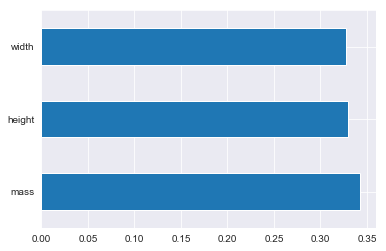

In [244]:
feat_importance = pd.Series(model.feature_importances_, index = X.columns)
feat_importance.nlargest(10).plot(kind = 'barh')
plt.savefig('fruits_featureI')
plt.show()

#### Test the base classifier

In [245]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [246]:
# Train the classifier using the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [247]:
# Estimate the accuracy of the classifier on future data, using the test data
knn.score(X_test, y_test)

0.8

After scalling & feature selection the accuracy went up. Which proves the model can be improved

In [248]:
# Use the trained k-NN classifier model to classify new, previously unseen objects
# first example: a small fruit with mass 20g, width 4.3 cm, height 5.5 cm
fruit_prediction = knn.predict([[20, 4.3, 5.5]])
look_up_fruit_name[fruit_prediction[0]]

'orange'

In [249]:
fruit_prediction = knn.predict([[100, 6.3, 8.5]])
look_up_fruit_name[fruit_prediction[0]]

'orange'

In [250]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2 0 2 0]
 [0 2 0 0]
 [1 0 3 0]
 [0 0 0 5]]
              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       1.00      1.00      1.00         2
           3       0.60      0.75      0.67         4
           4       1.00      1.00      1.00         5

    accuracy                           0.80        15
   macro avg       0.82      0.81      0.81        15
weighted avg       0.80      0.80      0.80        15



In [251]:
#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(),
              'Stochastic Gradient Descent' : SGDClassifier(),
              'Random Forest': RandomForestClassifier(),
              'Decsision Tree': DecisionTreeClassifier(),
              'AdaBoost': AdaBoostClassifier(),
              'Gaussian Naive Bayes': GaussianNB(),
              'XGBClassifier' : XGBClassifier(),
              'Gradient Boosting Classifier' : GradientBoostingClassifier(),
              'Linear Discriminant Analysis' : LinearDiscriminantAnalysis(),
              'LogisticRegression' : LogisticRegression(),
              'ExtraTreesClassifier' : ExtraTreesClassifier()}


#Function to get the scores for each model 
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

[10:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model_name,accuracy_score,precision_score,recall_score,f1_score
6,XGBClassifier,0.80,0.84,0.82,0.83
10,ExtraTreesClassifier,0.80,0.84,0.82,0.83
1,Stochastic Gradient Descent,0.80,0.82,0.81,0.81
5,Gaussian Naive Bayes,0.80,0.82,0.81,0.81
2,Random Forest,0.73,0.81,0.78,0.78
8,Linear Discriminant Analysis,0.73,0.75,0.75,0.73
3,Decsision Tree,0.60,0.70,0.65,0.66
7,Gradient Boosting Classifier,0.53,0.70,0.60,0.61
4,AdaBoost,0.53,0.59,0.60,0.53
9,LogisticRegression,0.53,0.46,0.46,0.43


The best performing model based on the results above is Random Forest Classifier

#### Parameter Tunning

In [252]:
from datetime import datetime

In [253]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [261]:
# n_estimators Number of trees in random forest
# max_features Number of features to consider at every split
# max_depth Maximum number of levels in tree
# Minimum number of samples required to split a node
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

gridsearch = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

In [262]:
start_time = timer(None) # timing starts from this point for "start_time" variable
model = gridsearch.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 3 minutes and 41.86 seconds.


In [263]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [264]:
rf_best_model = RandomForestClassifier(criterion = 'gini',
 max_depth = 4, max_features = 'auto', n_estimators = 200)

In [265]:
print("Best performing classification report")
print("Random Forest Classifier")
rf_best_model.fit(X_train, y_train)
pred = rf_best_model.predict(X_test)
#print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('Accuracy is %s' % accuracy_score(pred, y_test))

Best performing classification report
Random Forest Classifier
              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       1.00      1.00      1.00         2
           3       0.60      0.75      0.67         4
           4       1.00      1.00      1.00         5

    accuracy                           0.80        15
   macro avg       0.82      0.81      0.81        15
weighted avg       0.80      0.80      0.80        15

Accuracy is 0.8
